Referenece : https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

In [2]:
max_length = 52
top_k = 5000

In [3]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = 24015 // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [4]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [5]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [6]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [7]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [8]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [9]:
import pickle

with open ('list_1.ob', 'rb') as fp:
    train_captions = pickle.load(fp)

In [10]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [11]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [12]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [13]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Prediction Caption: zipper bright envelope assembling blender lid borders follows personal rock situated river camera caterpillar balance apples appearing muffins darkened dimly personalized banners dries stops enforcement malnourished frisbees lincoln shrub dozen salad sandwhich unplugged or urban stocked fingers area tickets oakland headphones desert shiny jumps earth buffet luggage reader ribbon maker memory gather


<ipython-input-13-81c52a4eee3c>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(grid_size, grid_size, i+1)
<ipython-input-13-81c52a4eee3c>:15: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


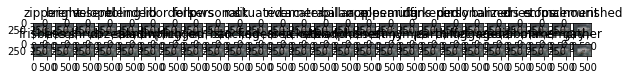

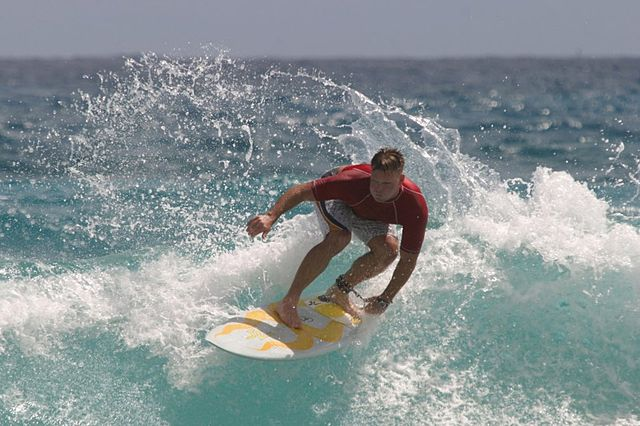

In [14]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [15]:
encoder.load_weights("encoder100.h5")
decoder.load_weights("decoder100.h5")

# encoder.load_weights("encoder.h5")
# decoder.load_weights("decoder.h5")

Prediction Caption: a surfer riding a wave on a wave <end>


<ipython-input-13-81c52a4eee3c>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(grid_size, grid_size, i+1)


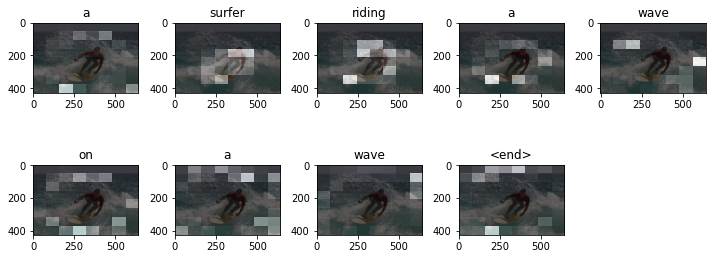

In [16]:
image_url = 'https://tensorflow.org/images/surf.jpg'
# image_url = 'https://homepages.cae.wisc.edu/~ece533/images/airplane.png'
# image_url = 'https://homepages.cae.wisc.edu/~ece533/images/boat.png'
# image_url = 'https://homepages.cae.wisc.edu/~ece533/images/girl.png'

image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
# Image.open(image_path)

## Input Image as numpy array

In [17]:
def evaluate_gradio(img):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(img, 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

 - Test

In [18]:
import cv2
import tensorflow as tf

image = cv2.imread("maksssksksss3.png")

img = tf.image.resize(image, (299, 299))
img = tf.keras.applications.inception_v3.preprocess_input(img)

caption, attention_plot = evaluate_gradio(img)
caption

['a', 'woman', 'in', 'white', 'sinks', 'of', 'men', '<end>']

## Convert text to Audio

In [19]:
caption = ['three','friends','are','separated','by','a','standing','near','each','other','<end>']

caption = ' '.join([str(elem) for elem in caption[:-1]])
print(caption)

three friends are separated by a standing near each other


In [20]:
from gtts import gTTS

language = 'en'
audio = gTTS(text=caption, lang=language, slow=False)
audio.save("audio.mp3")

In [21]:
# ! pip install google_trans_new

In [22]:
from google_trans_new import google_translator

translator = google_translator()  
translate_text = translator.translate(caption, lang_tgt='ml')  
print(translate_text)

മൂന്ന് സുഹൃത്തുക്കൾ പരസ്പരം ഒരു നിലകൊള്ളാൽ വേർതിരിക്കുന്നു 


## Plot attention spectrum

In [23]:
def plot_attention_gr(image, result, attention_plot):
    temp_image = image

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [24]:
import cv2
import tensorflow as tf

image = cv2.imread("maksssksksss3.png")

In [25]:
# plot_attention_gr(img, result, attention_plot)

## Gradio UI Componenets

In [26]:
def get_lang_code(lang):
    if lang == "English":
        lang = "en"
    elif lang == "Hindi":
        lang = "hi"
    elif lang == "Tamil":
        lang = "ta"
    elif lang == "Polish":
        lang = "pl"
    elif lang == "Malayalam":
        lang = "ml"
    else:
        lang = "en"
    return lang

In [27]:
from gtts import gTTS
from google_trans_new import google_translator

def get_caption(image1, algo, lang):
    
    image2 = image1
    
#     if algo == "CNN+RNN":
    img = tf.image.resize(image, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    caption, attention_plot = evaluate_gradio(img)
    caption = ' '.join([str(elem) for elem in caption[:-1]])

    lang = get_lang_code(lang)
    translator = google_translator() 

    translated_text = translator.translate(caption, lang_tgt=lang)

    audio = gTTS(text = translated_text, lang=lang, slow=False)
    audio.save("audio.mp3")
    
    return  "audio.mp3", caption, translated_text

In [30]:
import gradio as gr

img = gr.inputs.Image()

title = "Image Captioning"

image1 = gr.inputs.Image( type="numpy")
algo = gr.inputs.Radio(["CNN+RNN"], label="Algorithm")
lang = gr.inputs.Radio(["English", "Malayalam", "Hindi", "Tamil", "Polish"], label="Choose Language")

# image2 = gr.outputs.Image(type="numpy", label="Output")

audio = gr.outputs.Audio(type="auto", label=None)

caption = gr.outputs.Textbox(type="auto", label="Label")
translated_text = gr.outputs.Textbox(type="auto", label="Translated Label")

gr.Interface(get_caption, inputs = [image1, algo, lang],   
             outputs = [audio, caption, translated_text], 
             title=title,
             live=False).launch(share=True)

IMPORTANT: You are using gradio version 1.4.0, however version 1.5.0 is available, please upgrade.
--------
Running locally at: http://127.0.0.1:7863/
This share link will expire in 24 hours. If you need a permanent link, email support@gradio.app
Running on External URL: https://37890.gradio.app
Interface loading below...


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7863/',
 'https://37890.gradio.app')